# Cross-Validation of `stepwise` model

Make a k-fold cross-validation using natural years. _Leave-one-(natural year)-out_

In [1]:
# Load packages
suppressMessages(library(lubridate))
suppressMessages(library(tidyverse))
suppressMessages(library(openair))

suppressMessages(library(caret))
suppressMessages(library(leaps))
suppressMessages(library(BBmisc))

In [2]:
suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=10,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [3]:
# Working directory
setwd("~/Repositories/AirQualityCOVID")

## Representative sample 

In [4]:
sites.lv <- c("es0118a", "es1438a") # Big cities (Madrid and Barcelona)",
sites.lv <- c(sites.lv, "es1580a", "es1340a") # small cities (Santander and Huelva)

## DataFrame Creation

In [5]:
# Create dataSet
load("data/data_AQ.rda")
load("data/meteorology.rda")

aq <- data_AQ %>%
            filter(site %in% sites.lv,
                   date < ymd("2020-01-01")
                  ) %>%
            timeAverage(avg.time = "day", type=c("site", "variable"))
aq$date <- as_date(aq$date)

mto <- data_Mto %>%
            filter(site %in% sites.lv,
                   date < ymd("2020-01-01"))

df <- merge(aq, mto,
              by = c("date", "site"), all.x=T) %>%
        drop_na() %>%
        mutate_if(is.factor, as.character) %>%
        select(-date_end, -process, -summary, -validity)

rm(data_AQ)
rm(data_Mto)

## PreProcess

In [6]:
deseason <- function(cl) {
    # Remove seasonal component of the additive time serie.
    #     This function is called below by an apply
    
    dcomp <- decompose(ts(cl, frequency = 365))

    cl - dcomp$seasonal
}


scale.df <- function(df, omit.cl) {
    # Scale dataframe ignoring no numeric columns (omit.cl)
    
    df[, omit.cl] <- scale(df[, omit.cl])
    df
}


range.df <- function(df, omit.cl) {
    # Scale dataframe ignoring no numeric columns (omit.cl)
    
    split.df <- df[, -omit.cl]
    
    cbind(df[, omit.cl], 
          normalize(split.df, method = "range", 
                    range = c(0, 1), margin = 1))
}

## Cross-Validation

In [7]:
leave.one.year.out <- function(yr, dat, omit.cl) { 
    # Do k-iteration of k-fold cv by pop yr data for test 
    #     and the rest for training
    # @params: omit.cl: columns to omit in the regression
    
    test <- which(year(dat$date) == yr)
    train <- which(year(dat$date) != yr)

    if(length(test) == 0 | length(train) == 0) {
        return
    }

    model <- train(value ~., 
                   data=dat[, -omit.cl], subset=train,
                   method="leapSeq",
                   tuneGrid = data.frame(nvmax = 1:11),
                  )
    print(model$bestTune$nvmax)

    y.th <- predict(model, newdata=dat[test,])
    
    data.frame("bias"=mean(y.th) / mean(dat[test,]$value),
               "var.ratio"=var(y.th) / var(dat[test,]$value),
               "cor"=cor(y.th, dat[test,]$value, method = "pearson")
              )
}

In [8]:
years <- 2013:2019

no.num.cl <- 1:3 # no numeric columns 
cv.df <- data.frame()

# Create one model for each pair of station-pollutant
for (st in sites.lv) {
    data.st <- df[df$site == st,]
    
    for (pll in levels(as.factor(data.st$variable))) {
        dat <- data.st[data.st$variable == pll, ]
        
        if (sum(!is.na(dat$date)) > (365*2)) {
            # if there is enough data (more than 2 years), deseasonalized
            dat <- cbind(dat[, no.num.cl],
                         apply(dat[, -no.num.cl], 2, deseason))
        }
        
        ds.dat <- range.df(dat, no.num.cl)
        
        cv.row <- do.call(rbind, lapply(years, leave.one.year.out,
                                        ds.dat, no.num.cl))

        cv.df <- rbind(cv.df,
                       cbind(data.frame("variable"=pll,
                                        "site"=st),
                             rbind(colMeans(cv.row, na.rm=T)))
                       )
    }
}

[1] 10
[1] 10
[1] 7
[1] 10
[1] 10
[1] 10
[1] 7
[1] 6
[1] 7
[1] 7
[1] 5
[1] 6
[1] 6
[1] 6
[1] 10
[1] 7
[1] 10
[1] 10
[1] 10
[1] 10
[1] 10
[1] 4
[1] 4
[1] 11
[1] 8
[1] 6
[1] 7
[1] 4
[1] 10
[1] 5
[1] 5
[1] 5
[1] 5
[1] 5
[1] 5
[1] 9
[1] 10
[1] 9
[1] 11
[1] 9
[1] 9
[1] 9
[1] 10
[1] 6
[1] 10
[1] 6
[1] 10
[1] 10
[1] 11
[1] 11
[1] 11
[1] 11
[1] 11
[1] 11
[1] 11
[1] 7
[1] 7
[1] 7
[1] 7
[1] 7
[1] 7
[1] 6
[1] 6
[1] 6
[1] 5
[1] 5
[1] 4
[1] 6
[1] 5
[1] 6
[1] 11
[1] 11
[1] 11
[1] 11
[1] 11
[1] 11
[1] 11
[1] 10
[1] 11
[1] 11
[1] 11
[1] 11
[1] 11
[1] 8
[1] 11
[1] 11
[1] 11
[1] 6
[1] 11
[1] 11
[1] 11
[1] 10
[1] 7
[1] 6
[1] 10
[1] 10
[1] 10
[1] 10


In [9]:
cv.df

variable,site,bias,var.ratio,cor
<chr>,<chr>,<dbl>,<dbl>,<dbl>
no,es0118a,1.0003438,0.2873697,0.5032561
no2,es0118a,1.0062696,0.3928622,0.5545036
o3,es0118a,1.0007097,0.2953215,0.5142917
pm10,es0118a,0.9999514,0.2627854,0.4949069
pm2.5,es0118a,1.0004715,0.2788964,0.5142245
no,es1438a,1.0008552,0.1888174,0.3979009
no2,es1438a,1.0050143,0.2683655,0.5038500
o3,es1438a,1.0136380,0.5392757,0.6478602
no,es1580a,1.0007222,0.2438173,0.4564296


In [10]:
mean.cv.df <- cv.df %>%
                group_by(variable) %>%
                summarise(var.ratio=mean(var.ratio),
                          bias=mean(bias),
                          cor=mean(cor)
                         ) %>%
                print()

# A tibble: 5 x 4
  variable var.ratio  bias   cor
* <chr>        <dbl> <dbl> <dbl>
1 no           0.248  1.00 0.462
2 no2          0.364  1.01 0.549
3 o3           0.417  1.01 0.581
4 pm10         0.233  1.00 0.431
5 pm2.5        0.279  1.00 0.514


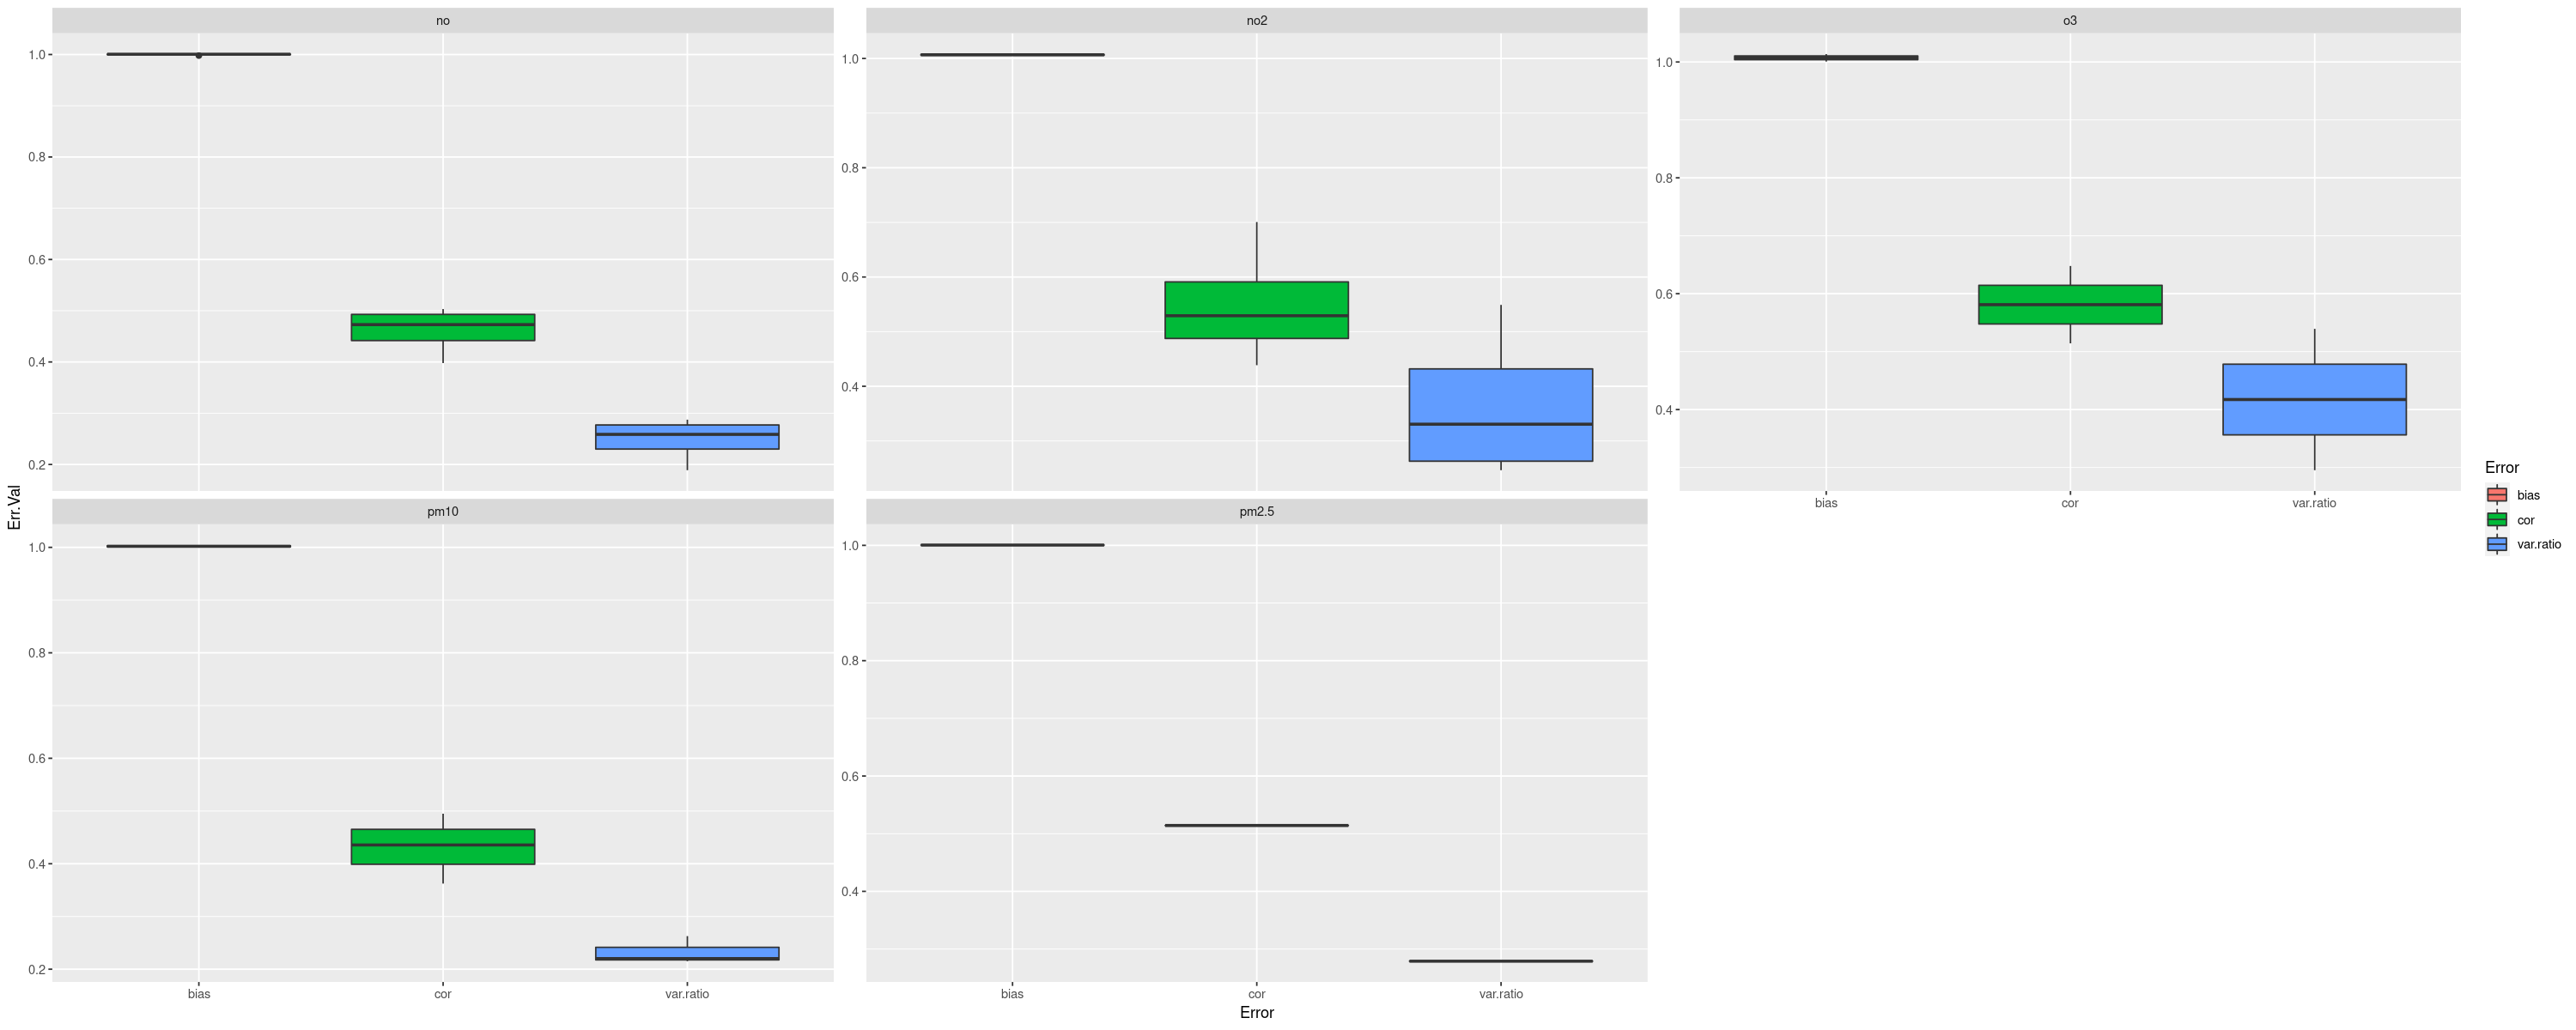

In [11]:
pivot.cv.df <- cv.df %>%
        pivot_longer(cols = c(3:ncol(cv.df)), 
                     names_to = "Error", values_to = "Err.Val")

ggplot(data=pivot.cv.df, aes(x=Error, y=Err.Val, fill=Error)) +
        geom_boxplot() + 
        facet_wrap(~variable, scales = "free_y")